# U-net Paper Replication

- Original Paper: https://arxiv.org/abs/1505.04597

In [ ]:
!nvidia-smi

In [2]:
import torch
from torch import nn
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.2+cu121
torchvision version: 0.17.2+cu121


In [3]:
import os
import sys
from pathlib import Path

sys.path.insert(0, str(Path(os.getcwd()).parent))

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda


In [5]:
BATCH_SIZE = 8
IMAGE_SIZE = (256, 512)
NUM_WORKERS = 2

SEED = 42

## 01. Data

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

from src.data.dataset import DATASET_NAME
from src.data.dataloader import get_dataloaders


transform_train = A.Compose(
    [
        A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
        A.HorizontalFlip(),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        A.ToGray(p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

transform_test = A.Compose(
    [
        A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

train_dataloader, test_dataloader, num_classes = get_dataloaders(
    dataset=DATASET_NAME.CITYSCAPES,
    root=Path("/home/geri/work/dataset/cityscapes"),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    transform_train=transform_train,
    transform_test=transform_test,
)

(-0.5, 511.5, 255.5, -0.5)

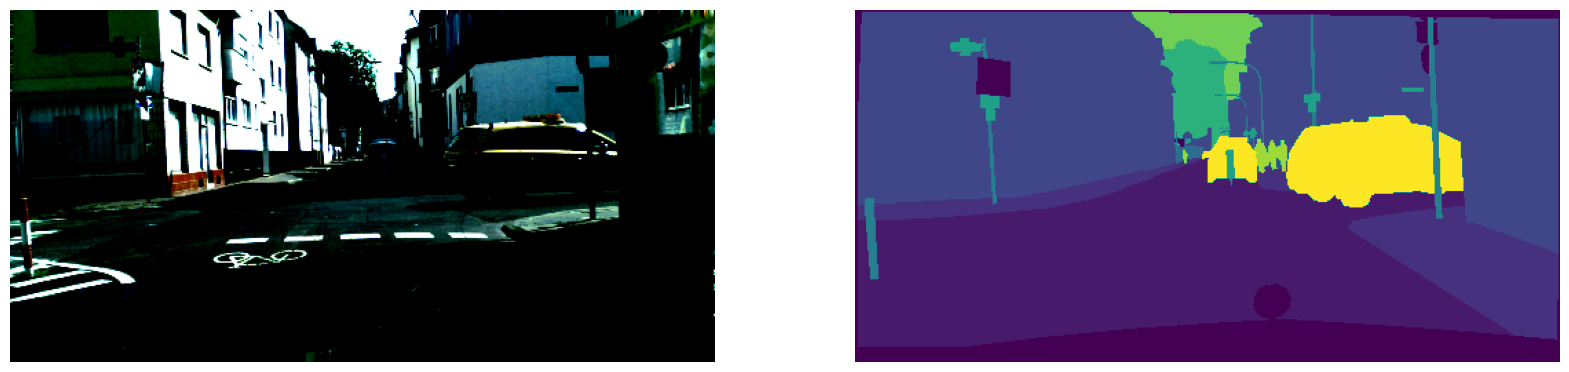

In [7]:
import matplotlib.pyplot as plt

img, target = next(iter(test_dataloader))

fig = plt.figure(figsize=(20, 30))

fig.add_subplot(1, 2, 1)
plt.imshow(img[0].permute(1, 2, 0))
plt.axis(False)

fig.add_subplot(1, 2, 2)
plt.imshow(target[0])
plt.axis(False)

In [8]:
import numpy as np

print(f"Image Size: {img[0].shape}\tTarget Size: {target[0].shape}")
print(f"Labels in target image: {np.unique(target[0])}")

Image Size: torch.Size([3, 256, 512])	Target Size: torch.Size([256, 512])
Labels in target image: [ 0  1  2  3  5  6  8  9 11 12 14]


## 02. Model

In [9]:
from src.models.unet.unet import UNet
from torchinfo import summary

model = UNet(out_channels=num_classes).to(device)

summary(
    model,
    input_size=(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                                   [1, 3, 256, 512]     [1, 20, 256, 512]    --                   True
├─Encoder (encoder)                           [1, 3, 256, 512]     [1, 512, 16, 32]     --                   True
│    └─ModuleList (layers)                    --                   --                   (recursive)          True
│    │    └─DoubleConv (0)                    [1, 3, 256, 512]     [1, 64, 256, 512]    38,848               True
│    └─MaxPool2d (pool)                       [1, 64, 256, 512]    [1, 64, 128, 256]    --                   --
│    └─ModuleList (layers)                    --                   --                   (recursive)          True
│    │    └─DoubleConv (1)                    [1, 64, 128, 256]    [1, 128, 128, 256]   221,696              True
│    └─MaxPool2d (pool)                       [1, 128, 128, 256]   [1, 128, 64, 128] 

## 03. Train

In [10]:
import src.utils.loggers as loggers

root = Path(os.getcwd()).parent
writer = loggers.create_tensorboard_writer(
    path=root / "runs",
    experiment_name="Cityscapes_Segmentation",
    model_name="U-Net",
    extra="batch-8_lr-10e-4_weight-decay-10e-7_dice-loss_lr-scheduler",
)

model_saver = loggers.ModelSaver(path=root / "checkpoints", model_name="U-Net")

In [ ]:
from src.models.train import train
from src.utils.losses import DiceLoss

EPOCHS = 100

loss_fn = DiceLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=10e-4, weight_decay=10e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=EPOCHS, eta_min=10e-5)

train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    device=device,
    writer=writer,
    model_saver=model_saver,
    use_amp=True,
)

## 04. Inference

In [12]:
from src.data.dataset import CITYSCAPES


def predict(
    model: nn.Module,
    img: torch.Tensor,
    target: torch.Tensor,
    device: torch.device,
) -> None:

    model.eval()
    with torch.inference_mode():

        pred = model(img.to(device=device))

        fig = plt.figure(figsize=(img.shape[0] * 2, 30))

        for i in range(img.shape[0]):
            fig.add_subplot(img.shape[0], 2, 2 * i + 1)
            plt.imshow(CITYSCAPES.decode_tensor(pred[i]))
            plt.title("Pred")
            plt.axis(False)

            fig.add_subplot(img.shape[0], 2, 2 * i + 2)
            plt.imshow(CITYSCAPES.decode_tensor(target[i]))
            plt.title("GT")
            plt.axis(False)

In [13]:
def load_checkpoint(path, model, optimizer=None, scheduler=None, scaler=None):

    checkpoint = torch.load(path)

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    if scaler is not None:
        scaler.load_state_dict(checkpoint["scaler_state_dict"])

    loss_fn_state = checkpoint.get("loss")

    return checkpoint["epoch"], loss_fn_state

In [15]:
model = UNet(out_channels=num_classes).to(device=device)

load_checkpoint(path="/home/geri/work/u-net_paper_replication/checkpoints/U-Net_epoch-94_best.pth", model=model)

(94, None)

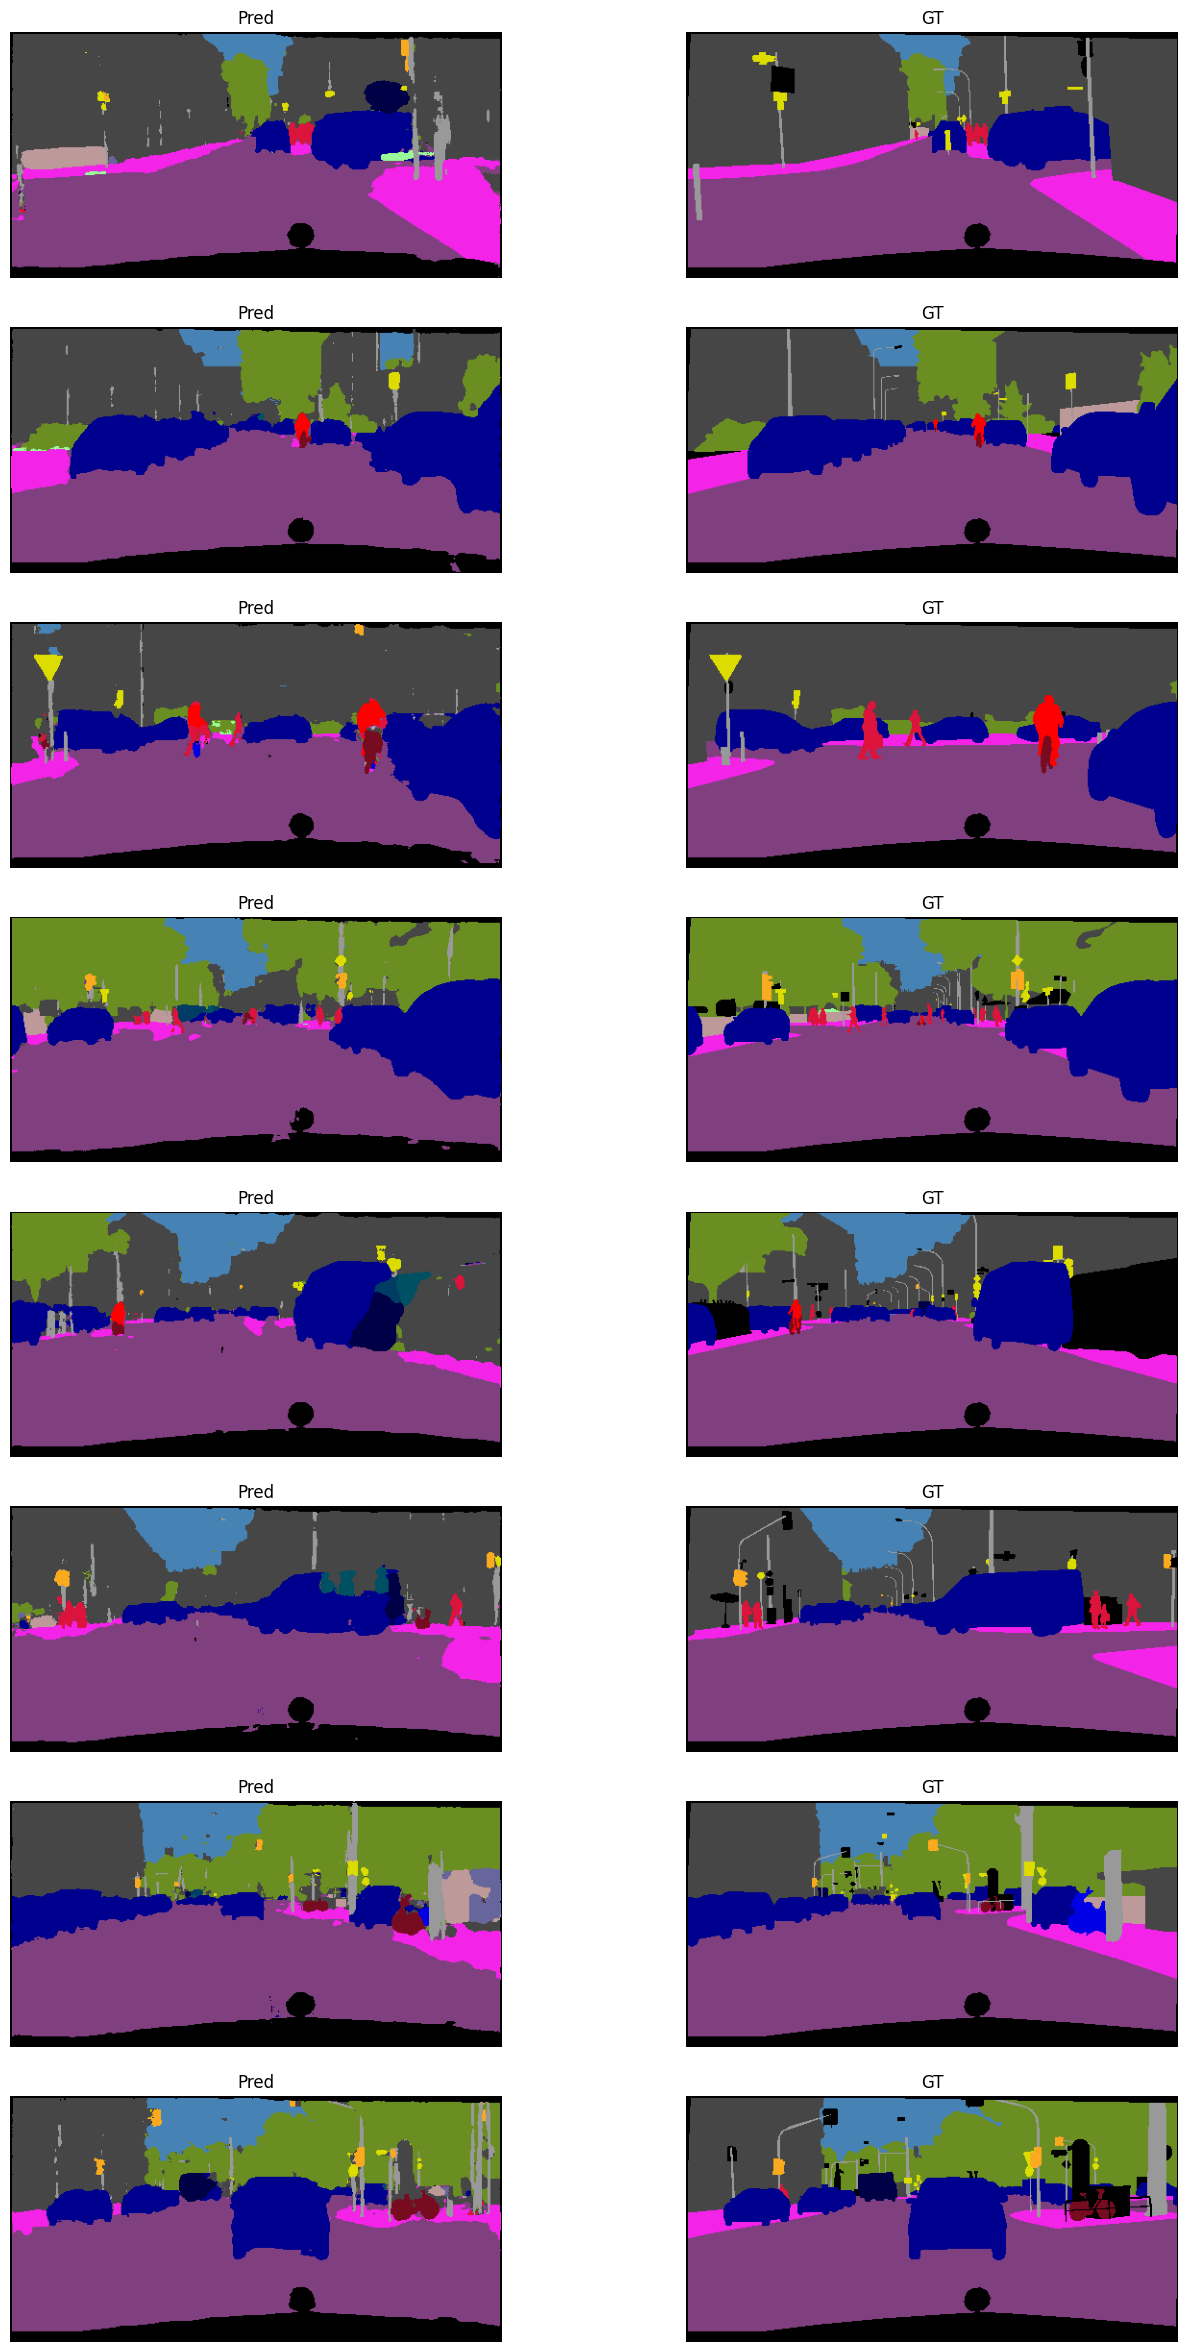

In [16]:
xs, ys = next(iter(test_dataloader))

predict(model=model, img=xs, target=ys, device=device)